## Project Overview
**This project aims to detect defects in sheet metal images using a PatchCore-style anomaly detection pipeline and evaluation on normal vs defective samples.**

## Dataset Composition
- **train/good :**  Normal training images<br>
- **validation/good :** Normal validation images<br>
- **test_public/ :** 
    - good: Normal test images
    - bad: Evaluation images (normal and defective)<br>
    - ground_truth: Defect masks (optional, matched by filename)

### 1. Imports & Configurations
- Import required libraries and set up reproducibility
- Define ROOT data path and configure device (CPU/GPU) with fixed random seeds

In [ ]:
import os
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models

import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

ROOT = r"...\sheet_metal"
# "data/sheet_metal"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


device: cuda


### 2. Utilities
- Image utilities: load paths, read sizes, and preprocess images
- Preprocessing: pad → resize → illumination normalize → tensor (ImageNet norm)

In [2]:
EXTS = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff")

def list_imgs(folder: str, recursive: bool = False):
    paths = []
    if recursive:
        for e in EXTS:
            paths += glob.glob(os.path.join(folder, "**", e), recursive=True)
    else:
        for e in EXTS:
            paths += glob.glob(os.path.join(folder, e))
    return sorted(paths)

def stem_lower(p: str) -> str:
    return Path(p).stem.lower()

def read_size(p: str):
    im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    return (im.shape[:2] if im is not None else None)

# ImageNet norm
IM_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IM_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_bgr(img, out_hw=(384, 384)):
    """Square pad → resize → illumination flatten (blurred division) → gray CLAHE-like via normalize → to 3ch"""
    h, w = img.shape[:2]
    side = max(h, w)
    pad = ((side - h) // 2, (side - w) // 2)
    img = cv2.copyMakeBorder(img, pad[0], side - h - pad[0], pad[1], side - w - pad[1], cv2.BORDER_REFLECT)
    img = cv2.resize(img, out_hw, interpolation=cv2.INTER_AREA)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    base = cv2.GaussianBlur(gray, (0, 0), 21)
    norm = cv2.normalize((gray.astype(np.float32) + 1) / (base + 1), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return cv2.cvtColor(norm, cv2.COLOR_GRAY2BGR)

def load_tensor(path: str):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    assert im is not None, f"Failed to load image: {path}"
    im = preprocess_bgr(im)  # (H, W, 3), BGR uint8
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    im = (im - IM_MEAN) / IM_STD
    ten = torch.from_numpy(im.transpose(2, 0, 1)).unsqueeze(0).to(device)  # [1, 3, H, W]
    return ten

### 3. Backbone feature extractor (ConvNeXt-Tiny):
- Capture stage2 & stage3 features via hooks, upsample + concat
- Apply avg pooling and channel-wise L2 normalization
- Output patch-level embeddings [Npatch, C] with spatial shape (H, W)

In [3]:
class BackboneExtractor(torch.nn.Module):
    def __init__(self, name="convnext_tiny", pretrained=True):
        super().__init__()
        self.name = name.lower()
        self.model, self._fetch = self._build(self.name, pretrained)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def _build(self, name, pretrained):
        if name == "convnext_tiny":
            w = models.ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
            m = models.convnext_tiny(weights=w)

            feats = {}
            def hook_i(i):
                def _h(_, __, out):
                    feats[i] = out
                return _h

            # convnext.features: [stage0, stage1, stage2, stage3]
            m.features[2].register_forward_hook(hook_i("l2"))  # C=384
            m.features[3].register_forward_hook(hook_i("l3"))  # C=768

            def fetch():
                l2, l3 = feats["l2"], feats["l3"]
                l3_up = F.interpolate(l3, size=l2.shape[-2:], mode="bilinear", align_corners=False)
                f = torch.cat([l2, l3_up], dim=1)   # C = 384 + 768 = 1152
                f = F.avg_pool2d(f, 3, 1, 1)        # smooth
                f = F.normalize(f, p=2, dim=1)      # channel-wise L2 normalize
                return f

            return m, fetch
        else:
            raise ValueError(f"Unsupported backbone: {name}")

    @torch.no_grad()
    def forward(self, x):
        _ = self.model(x)      # fill hooks
        f = self._fetch()      # [B, C, H, W]
        B, C, H, W = f.shape
        emb = f.permute(0, 2, 3, 1).contiguous().view(B * H * W, C)  # [B*H*W, C]
        return emb, (H, W)

@torch.no_grad()
def extract_feats(x: torch.Tensor):
    emb, hw = bb(x)
    return emb.cpu().numpy().astype("float32"), hw


### 4. Dataset discovery and sanity checks:
- Load image paths for train/validation/test and ground-truth masks
- Build filename-based map (bad image ↔ mask) and report unmatched pairs
- Spot-check 10 pairs for image–mask resolution consistency

In [4]:
# 0) Dataset layout & basic counts

train = list_imgs(os.path.join(ROOT, "train", "good"))
vali  = list_imgs(os.path.join(ROOT, "validation", "good"))
good  = list_imgs(os.path.join(ROOT, "test_public", "good"))
bad   = list_imgs(os.path.join(ROOT, "test_public", "bad"))
masks = list_imgs(os.path.join(ROOT, "test_public", "ground_truth"), recursive=True)

print(f"train/good: {len(train)}")
print(f"validation/good: {len(vali)}")
print(f"test_public/good: {len(good)}")
print(f"test_public/bad: {len(bad)}")
print(f"test_public/ground_truth: {len(masks)}  (→ Count must match bad images)")

# mask lookup via key (filename without '_mask')
mask_key_by_path = {}
for m in masks:
    key = stem_lower(m).replace("_mask", "")
    mask_key_by_path[key] = m

bad_keys = [stem_lower(b) for b in bad]

pairs = []
unmatched_bad = []
for bpath, key in zip(bad, bad_keys):
    m = mask_key_by_path.get(key)
    if m is not None:
        pairs.append((bpath, m))
    else:
        unmatched_bad.append(bpath)

extra_masks = [p for k, p in mask_key_by_path.items() if k not in set(bad_keys)]

print("Matched pairs:", len(pairs))
print("Bad images without masks:", len(unmatched_bad))
print("Masks without corresponding bad images:", len(extra_masks))
if unmatched_bad[:5]:
    print("Examples (missing):", [Path(p).name for p in unmatched_bad[:5]])

# Resolution consistency check (sample 10 pairs)
def safe_read_size(p):
    try:
        return read_size(p)
    except Exception:
        return None

for bpath, mpath in pairs[:10]:
    sb, sm = safe_read_size(bpath), safe_read_size(mpath)
    print(f"{Path(bpath).name} -> {Path(mpath).name} | size(img,mask) = {sb} {sm}")
print("checked pairs:", min(10, len(pairs)))


train/good: 137
validation/good: 19
test_public/good: 24
test_public/bad: 90
test_public/ground_truth: 90  (→ Count must match bad images)
Matched pairs: 90
Bad images without masks: 0
Masks without corresponding bad images: 0
000_overexposed.png -> 000_overexposed_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
000_regular.png -> 000_regular_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
000_shift_1.png -> 000_shift_1_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
000_shift_2.png -> 000_shift_2_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
000_shift_3.png -> 000_shift_3_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
000_underexposed.png -> 000_underexposed_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
001_overexposed.png -> 001_overexposed_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
001_regular.png -> 001_regular_mask.png | size(img,mask) = (1056, 4224) (1056, 4224)
001_shift_1.png -> 001_shift_1_mask.png | size(img,mask) = (1056, 4

### 5. Feature bank, FAISS index, and thresholding

- Build a feature bank from train/good, compress with a random coreset, and index using FAISS (L2).
- Define scoring functions (kNN distance map → top-k average) to compute anomaly scores.
- Derive threshold τ from validation/good scores (e.g., 70th percentile).

train/good images: 137
processed 50/137
processed 100/137
processed 137/137
raw bank shape: (315648, 384)
coreset bank shape: (31564, 384)
FAISS index ntotal: 31564
[Validation] images=19 | score mean=0.0599, std=0.0068, max=0.0744
[Threshold] τ_img (p70.0) = 0.0617


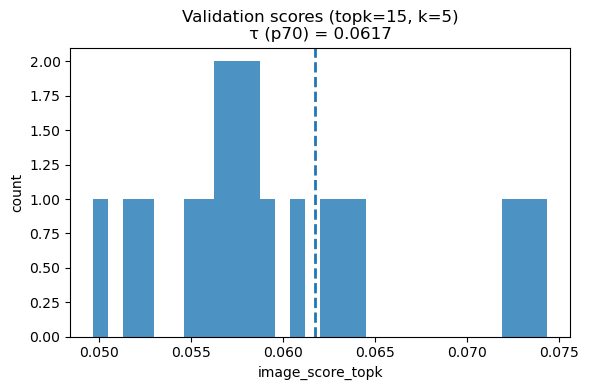

In [5]:
# 1) Backbone init

bb = BackboneExtractor("convnext_tiny", pretrained=True).to(device)


# 2) Feature bank from train/good

train_paths = train
print("train/good images:", len(train_paths))
assert len(train_paths) > 0, "No images found in train/good."

bank_parts = []
for i, p in enumerate(train_paths, 1):
    ten = load_tensor(p)
    e, _ = extract_feats(ten)
    bank_parts.append(e)
    if i % 50 == 0 or i == len(train_paths):
        print(f"processed {i}/{len(train_paths)}")

bank = np.concatenate(bank_parts, axis=0)
print("raw bank shape:", bank.shape) 

# Coreset: random 10% or at least 2000
rng = np.random.default_rng(SEED)
target = min(len(bank), max(len(bank) // 10, 2000))
keep = rng.choice(len(bank), size=target, replace=False)
bank = bank[keep]
print("coreset bank shape:", bank.shape)


# 3) FAISS index (L2 distance)

index = faiss.IndexFlatL2(bank.shape[1])
index.add(bank)
print("FAISS index ntotal:", index.ntotal)


# 4) Scoring (single path): top-k average on kNN mean-distance map

def infer_image_map_raw(path: str, k: int = 5):
    """Return unnormalized distance map (mean over k-NN per patch)."""
    ten = load_tensor(path)
    emb, hw = extract_feats(ten)
    kk = min(k, index.ntotal)  # guard
    D, _ = index.search(emb, kk)  # [Npatch, kk]
    return D.mean(axis=1).reshape(hw)

def image_score_topk(path: str, topk: int = 15, k: int = 5) -> float:
    """Image-level score = mean of top-k pixels in the raw kNN map."""
    s = infer_image_map_raw(path, k=k).ravel()
    top = np.partition(s, -topk)[-topk:]
    return float(top.mean())


# 5) τ from validation/good

val_paths = vali  
assert len(val_paths) > 0, f"No images found in validation/good: {os.path.join(ROOT, 'validation', 'good')}"

VAL_TOPK = 15
VAL_K = 5
TAU_PERCENTILE = 70.0

val_scores = [image_score_topk(p, topk=VAL_TOPK, k=VAL_K) for p in val_paths]
tau_img = float(np.percentile(val_scores, TAU_PERCENTILE))

print(f"[Validation] images={len(val_scores)} | score mean={np.mean(val_scores):.4f}, "
      f"std={np.std(val_scores):.4f}, max={np.max(val_scores):.4f}")
print(f"[Threshold] τ_img (p{TAU_PERCENTILE}) = {tau_img:.4f}")

# --- Visualization: validation score histogram with τ line ---
plt.figure(figsize=(6,4))
plt.hist(val_scores, bins=30, alpha=0.8)
plt.axvline(tau_img, linestyle='--', linewidth=2)
plt.title(f"Validation scores (topk={VAL_TOPK}, k={VAL_K})\nτ (p{TAU_PERCENTILE:.0f}) = {tau_img:.4f}")
plt.xlabel("image_score_topk"); plt.ylabel("count")
plt.tight_layout(); plt.show()

### 6. Evaluation on Test Set & Threshold Analysis

- Compute image-level scores on test_public and classify with τ.
- Plot ROC curve and score distributions (normal vs defect) with the threshold line.
- Run a threshold sweep to visualize how F1/Precision/Recall change vs threshold.

test_public | good: 24, bad: 90
[Image] AUROC=0.8681 | F1=0.899 | Precision=0.909 | Recall=0.889
Confusion Matrix (rows=true [normal,defect]):
 [[16  8]
 [10 80]]


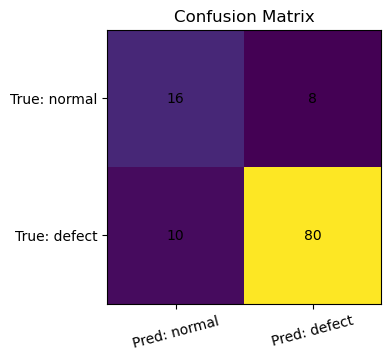

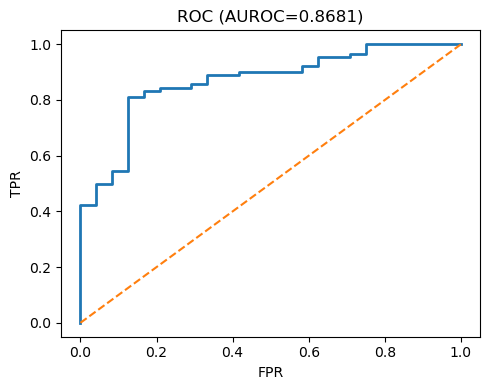

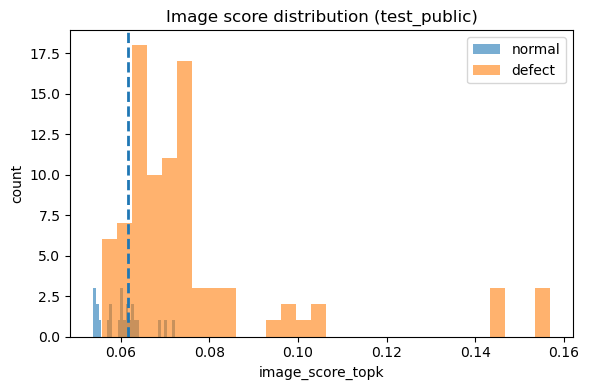

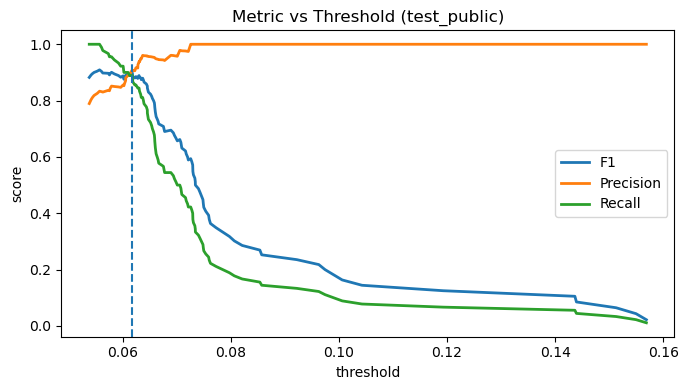

In [6]:
# 6) Evaluate on test_public (good/bad)

test_good = good
test_bad  = bad
print(f"test_public | good: {len(test_good)}, bad: {len(test_bad)}")

y_true, y_score, y_pred = [], [], []

for p in test_good:
    s = image_score_topk(p, topk=VAL_TOPK, k=VAL_K)
    y_true.append(0); y_score.append(s); y_pred.append(1 if s >= tau_img else 0)

for p in test_bad:
    s = image_score_topk(p, topk=VAL_TOPK, k=VAL_K)
    y_true.append(1); y_score.append(s); y_pred.append(1 if s >= tau_img else 0)

img_auc = roc_auc_score(y_true, y_score)
cm  = confusion_matrix(y_true, y_pred)  
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"[Image] AUROC={img_auc:.4f} | F1={f1:.3f} | Precision={prec:.3f} | Recall={rec:.3f}")
print("Confusion Matrix (rows=true [normal,defect]):\n", cm)

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# --- Confusion matrix heatmap ---
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xticks([0,1], ["Pred: normal","Pred: defect"], rotation=15)
plt.yticks([0,1], ["True: normal","True: defect"])
plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1], linestyle='--')
plt.title(f"ROC (AUROC={img_auc:.4f})")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.show()

# --- Distribution of image scores by class ---
y_true_np = np.array(y_true)
y_score_np = np.array(y_score)
scores_neg = y_score_np[y_true_np==0]
scores_pos = y_score_np[y_true_np==1]

plt.figure(figsize=(6,4))
plt.hist(scores_neg, bins=30, alpha=0.6, label="normal")
plt.hist(scores_pos, bins=30, alpha=0.6, label="defect")
plt.axvline(tau_img, linestyle='--', linewidth=2)
plt.title("Image score distribution (test_public)")
plt.xlabel("image_score_topk"); plt.ylabel("count"); plt.legend()
plt.tight_layout(); plt.show()

# --- Threshold sweep on test_public ---
ths = np.percentile(y_score, np.linspace(0,100,101))
f1s, pres, recs = [], [], []
for th in ths:
    yp = (np.array(y_score) >= th).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(y_true, yp, average='binary', zero_division=0)
    f1s.append(f1); pres.append(p); recs.append(r)

plt.figure(figsize=(7,4))
plt.plot(ths, f1s, label="F1", linewidth=2)
plt.plot(ths, pres, label="Precision", linewidth=2)
plt.plot(ths, recs, label="Recall", linewidth=2)
plt.axvline(tau_img, linestyle='--')
plt.title("Metric vs Threshold (test_public)")
plt.xlabel("threshold"); plt.ylabel("score"); plt.legend()
plt.tight_layout(); plt.show()

### 8. Visualization: Heatmaps & Mask Preview
- Pick sample IDs and overlay kNN distance heatmaps on originals.
- Show a side-by-side preview of one bad image and its matched mask (resized with NEAREST to match resolution).

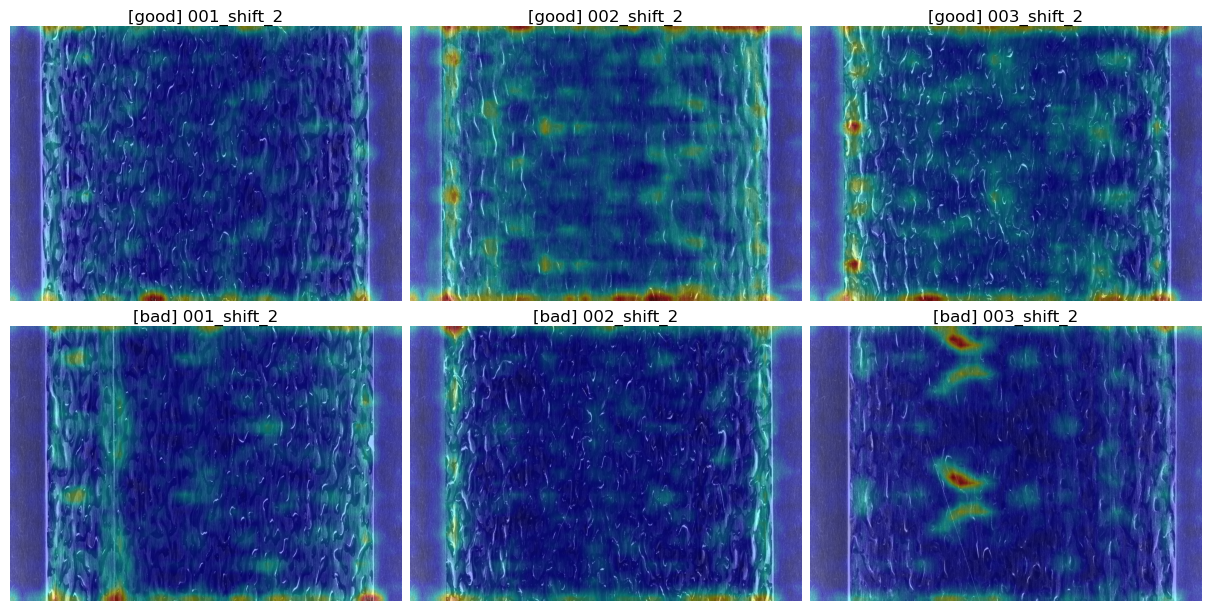

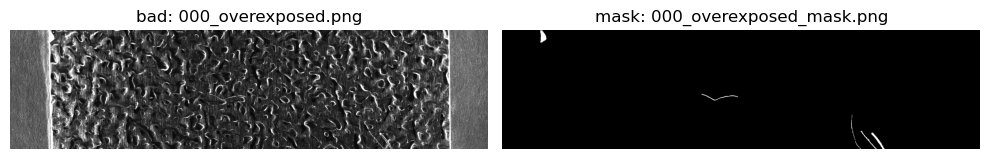

In [7]:
# 7) Sample visualization (3 good + 3 bad)
#    - Display-only min-max normalization for heatmap

from pathlib import Path
import matplotlib.pyplot as plt
import cv2

def pick_by_ids(paths, ids, cond):
    picked = []
    for p in paths:
        stem = Path(p).stem.lower()
        for i in ids:
            if stem.startswith(f"{i:03d}_{cond.lower()}"):
                picked.append(p)
                break
    return picked

# Select images for both good and bad
ids   = [1, 2, 3]
cond  = "shift_2"
good_pick = pick_by_ids(test_good, ids, cond)
bad_pick  = pick_by_ids(test_bad,  ids, cond)

sample_paths = [(p, "good") for p in good_pick] + [(p, "bad") for p in bad_pick]

fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)  
axs = axes.ravel()

for ax, (p, cls) in zip(axs, sample_paths):
    smap = infer_image_map_raw(p, k=VAL_K)
    smap_vis = (smap - smap.min()) / (smap.max() - smap.min() + 1e-8)

    src = cv2.imread(p)
    if src is None:
        print(f"[WARN] Failed to load image (skip visualization): {p}")
        ax.axis("off")
        continue

    smap_vis_rs = cv2.resize(smap_vis, (src.shape[1], src.shape[0]))
    heat = cv2.applyColorMap((smap_vis_rs * 255).astype('uint8'), cv2.COLORMAP_JET)
    over = cv2.addWeighted(src, 0.6, heat, 0.4, 0)

    ax.imshow(cv2.cvtColor(over, cv2.COLOR_BGR2RGB), aspect='auto')  
    ax.set_title(f"[{cls}] {Path(p).stem}", pad=2)
    ax.axis("off")

for ax in axs[len(sample_paths):]:
    ax.axis("off")

plt.show()

# ---------------------------
# 8) One sample mask visualization using recursive map (consistent with pairs)
# ---------------------------
if len(bad) > 0:
    b0 = bad[0]
    key0 = stem_lower(b0)
    m0 = mask_key_by_path.get(key0, None)
    if m0 is None:
        print(f"[INFO] No mask found for '{Path(b0).name}' (check folder structure).")
    else:
        im = cv2.cvtColor(cv2.imread(b0), cv2.COLOR_BGR2RGB)
        mk = cv2.imread(m0, cv2.IMREAD_GRAYSCALE)
        if mk is not None and (mk.shape[0] != im.shape[0] or mk.shape[1] != im.shape[1]):
            mk = cv2.resize(mk, (im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1); plt.imshow(im); plt.title(f"bad: {Path(b0).name}"); plt.axis('off')
        plt.subplot(1, 2, 2); plt.imshow(mk, cmap='gray'); plt.title(f"mask: {Path(m0).name}"); plt.axis('off')
        plt.tight_layout(); plt.show()
